In [1]:
# do the same thing as in the sine wave demo above but with one
# instance of a speakers vocals - prove that everything works correctly

import sys

import utils

sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Users/david/Documents/mastersCode/ubm/classifiers/fhmm/pmc_development', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [2]:
from importlib import reload
import audio_datastore.audio_datastore as myads
reload(myads)
from importlib import reload
from collections import Counter
import pickle
import time

Using cache found in /Users/david/.cache/torch/hub/snakers4_silero-vad_master
Using cache found in /Users/david/.cache/torch/hub/snakers4_silero-vad_master


In [3]:
from data.pitch_tracking_database.load_data import *
speech_pitch_tracking_db = pickle.load(open(normalised_30,'rb'))
ads = speech_pitch_tracking_db['ads']

In [5]:
# split ads
developmentLabels = ["M03","M04","M05","M06","M07","M08","M09","M10","F05","F06","F07","F08","F09","F10",
                     "F03","F04"]
evaluationLabels = ["M01","M02","F01","F02"]
adsTrain = myads.subset(ads, developmentLabels)
adsEvaluate = myads.subset(ads, evaluationLabels)
numFilesPerSpeakerForEnrollment = 20
adsEnroll, adsDet = myads.split(adsEvaluate, numFilesPerSpeakerForEnrollment)
adsTest = adsDet
# adsDet, adsTest = myads.split(adsDet, 2)
# adsTrain.info('Train')
# adsEnroll.info('Enroll')
# adsTest.info('Test')

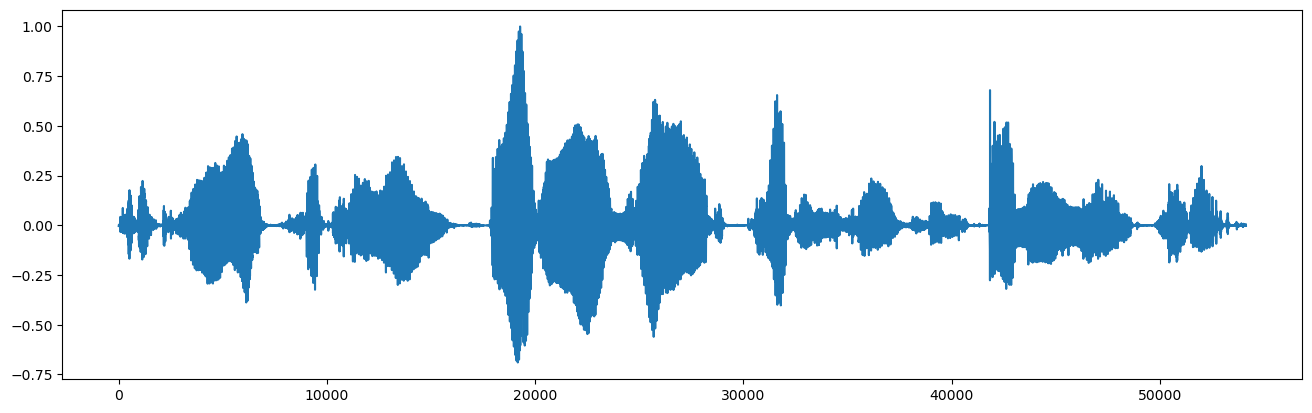

In [8]:
import matplotlib.pyplot as plt
speaker_audio = ads.data[0]
plt.plot(speaker_audio)

In [13]:
import utils
import numpy as np
speaker_ap = utils.get_average_power(speaker_audio)
print('speaker average power = ', speaker_ap)

speaker average power =  0.011383420750322636


In [22]:
snr_db = 10
noise_ap = speaker_ap / np.power(10, snr_db / 10)
noise_ap

0.0011383420750322635

In [24]:
speaker_audio.shape

(54144, 1)

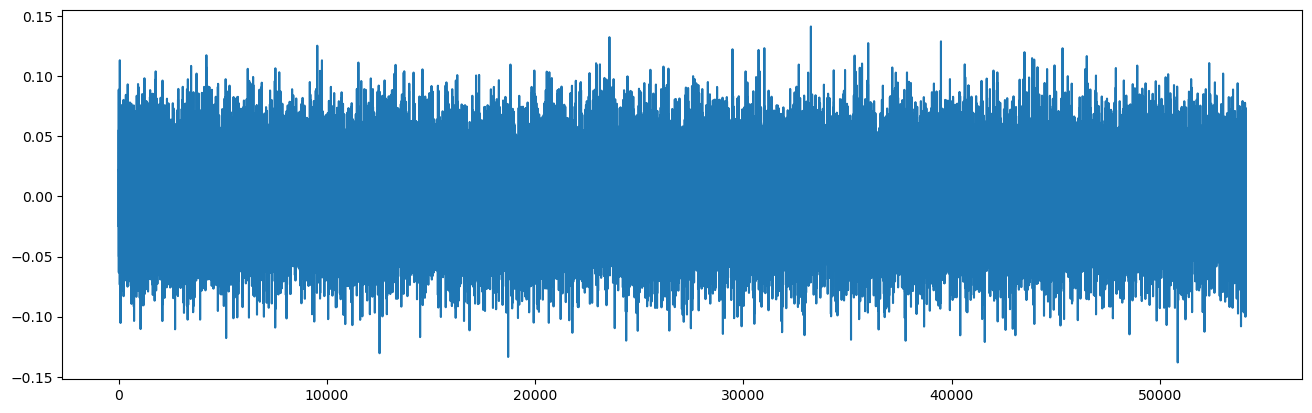

In [26]:
noise = np.random.normal(0, np.sqrt(noise_ap), speaker_audio.shape[0])
plt.plot(noise)


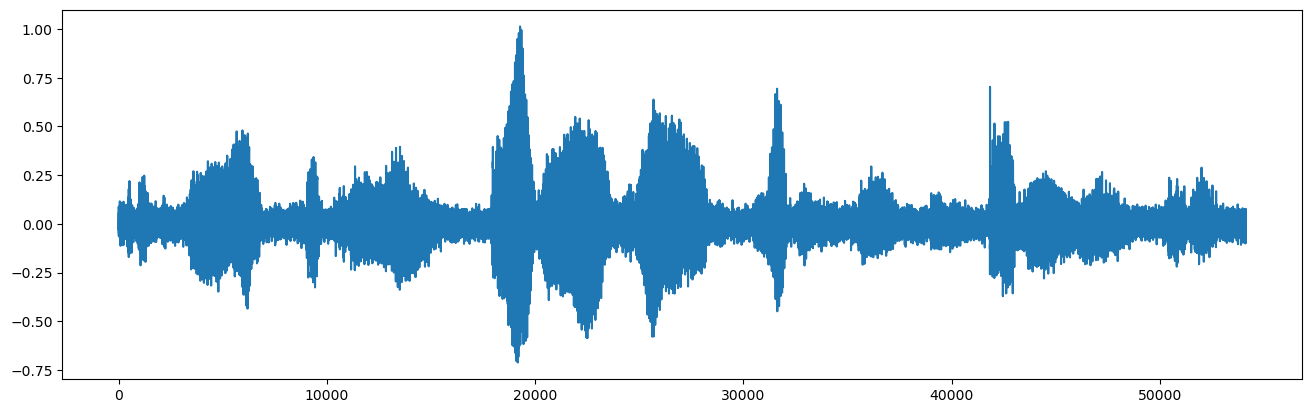

In [29]:
noisey_speaker = speaker_audio.flatten() + noise
plt.plot(noisey_speaker)